[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/ersip-sprint/blob/master/sprints/1/2%20-%20Load%20and%20display%20LiDAR%20raster.ipynb)

In [1]:
! pip install sap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 17.4 MB/s eta 0:00:00


In [2]:
from pathlib import Path # Manage folders and files
import rasterio as rio # Reads and writes geospatial raster data
from matplotlib import pyplot as plt # Display plots and images
import numpy as np # Multi-dimensional arrays

# Load and display LiDAR raster

The LiDAR raster files are located in the `data` folder. The rasters are in single band `TIFF` image format.

In [4]:
! wget https://github.com/kshitijrajsharma/ersip-sprint/raw/master/data/data.zip
! unzip data.zip
! rm data.zip

--2025-12-15 07:45:52--  https://github.com/kshitijrajsharma/ersip-sprint/raw/master/data/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kshitijrajsharma/ersip-sprint/master/data/data.zip [following]
--2025-12-15 07:45:52--  https://raw.githubusercontent.com/kshitijrajsharma/ersip-sprint/master/data/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43502915 (41M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  41.49M   141MB/s    in 0.3s    

2025-12-15 07:45:54 (141 MB/s) - ‘data.zip’ saved [43502915/43502915]

Archive:  data.zip
   crea

In [5]:
data_dir = Path('data')
list(data_dir.glob('*.tif'))

[PosixPath('data/dsm_vox_50cm_tile_-7_1.tif'),
 PosixPath('data/dsm_vox_50cm_tile_-12_0.tif'),
 PosixPath('data/dsm_vox_50cm_tile_-11_0.tif')]

## 1. Load and display a raster file

- Open the raster file and read the 2D array (tip: you can type `?function` to display docstrings, e.g. `?rio.open` )
- Read the 2D array
- Display the 2D array as an image
    + what can we do to visualize more details?

In [7]:
dsm_50cm= rio.open(data_dir / 'dsm_vox_50cm_tile_-7_1.tif').read(1)

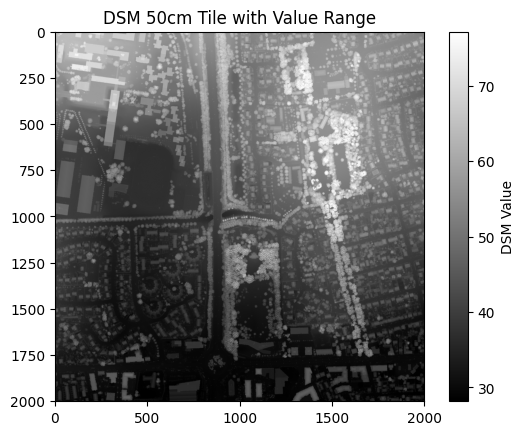

Minimum value of dsm_50cm: 28.15999984741211
Maximum value of dsm_50cm: 77.16000366210938


In [12]:
plt.imshow(dsm_50cm, cmap='gray')
plt.colorbar(label='DSM Value')
plt.title('DSM with Value Range')
plt.show()
print(f"Minimum value of dsm_50cm: {np.min(dsm_50cm)}")
print(f"Maximum value of dsm_50cm: {np.max(dsm_50cm)}")

## 2. Visualize flat zones in the DSM

- Find the values of the flat zones
    + Sort the unique values in a list (or an array) of levels
- Display some flat zones
    + Display the flatzones of $i^{th}$ level

In [10]:
print(dsm_50cm)

[[66.55506897 66.54903412 66.5374527  ... 53.18424225 53.13644028
  53.14580154]
 [66.59666443 66.57584381 66.57499695 ... 53.22000122 53.11000061
  53.11999893]
 [66.58999634 66.55999756 66.56999969 ... 53.13333511 53.11999893
  53.13268661]
 ...
 [30.71110535 30.77750015 30.86000061 ... 28.36499977 28.37750053
  28.37999916]
 [30.78487587 30.87333298 30.85666656 ... 29.97999954 29.90250015
  29.14500046]
 [30.76250076 30.84000015 30.80999947 ... 29.85000038 29.88333321
  29.90999985]]


In [17]:
type(dsm_50cm)

numpy.ndarray

In [18]:
dsm_50cm.shape

(2001, 2001)

In [28]:
unique_dsm_values = np.unique(dsm_50cm)
print(unique_dsm_values)


[28.15999985 28.16042709 28.16098976 ... 77.15499878 77.15666962
 77.16000366]


In [32]:
filtered_dsm_30m = dsm_50cm.copy()
filtered_dsm_30m[filtered_dsm_30m > 30] = np.nan

In [33]:
type(filtered_dsm_30m), filtered_dsm_30m.shape

(numpy.ndarray, (2001, 2001))

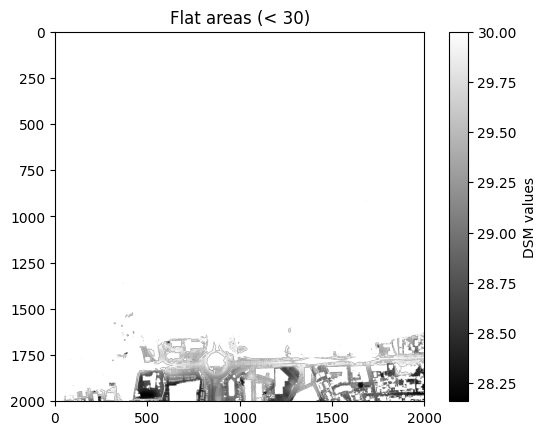

In [36]:
plt.imshow(filtered_dsm_30m, cmap='gray')
plt.colorbar(label='DSM values')
plt.title('Flat areas (< 30)')
plt.show()

## 3. Create a max-tree of the DSM

Building a max-tree from scratch is a challenging assignement 🙂

In [ ]:
# If you have time, you can start work on a max-tree algorithm